In [39]:
import sys
import os
import numpy as np
import xarray as xr
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.neuralnet import construct_modeldev_model, earlystop, BrierScore, ConstructorAndCompiler
#from Hybrid.optimization import multi_fit_multi_eval, multi_fit_single_eval, ranked_prob_score
from Hybrid.dataprep import test_trainval_split, multiclass_log_forecastprob, singleclass_regression, multiclass_logistic_regression_coefficients, scale_other_features
from Hybrid.interpretation import combine_input_output, composite_extremes

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

crossval = True # Only for the trainvalsplit.
nfolds = 3
balanced = True
focus_class = -1 # Index of the class to be scored and benchmarked through bss

name = 'tg-ex-q0.75-21D_ge7D_sep12-15'
#name = 'tg-ex-q0.75-21D_ge7D_sep19-21'
name2 = 'tg-anom_JJA_45r1_31D-roll-mean_sep12-15'

predictor_dir = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/no_pdomjo/') # Can change to the objectively selected sets
#predictor_dir = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/emp_duplicated/') # Can change to the objectively selected sets
for_obs_dir = Path('/nobackup/users/straaten/predsets/full/') 

predictors = pd.read_hdf(predictor_dir / f'{name2}_multi_d20_b3_predictors.h5', key = 'input').iloc[:,:8]
forc = pd.read_hdf(for_obs_dir / f'{name}_forc.h5', key = 'input')
obs= pd.read_hdf(for_obs_dir / f'{name}_obs.h5', key = 'target')

In [40]:
# Preparing only the trainval set.
X_test, X_trainval, generator = test_trainval_split(predictors, crossval = crossval, nfolds = nfolds, balanced = balanced)
forc_test, forc_trainval, generator = test_trainval_split(forc, crossval = crossval, nfolds = nfolds, balanced = balanced)
obs_test, obs_trainval, generator = test_trainval_split(obs, crossval = crossval, nfolds = nfolds, balanced = balanced)

feature_input, feature_scaler = scale_other_features(X_trainval)
raw_predictions = multiclass_log_forecastprob(forc_trainval)
obs_input = obs_trainval.values

fitting a new feature scaler


In [41]:
predictors

,variable,sst_nhplus,siconc_nhmin,transp_europe,swvl13_europe,sst,swvl4_europe,sst_nhplus,snowc_nhmin
,timeagg,21,31,31,15,21,21,21,31
,clustid,4,0,1,0,3,0,3,1
,metric,spatcov,mean,spatcov,mean,mean,spatcov,mean,mean
time,separation,,,,,,,,
1998-06-19,12,-0.051529,-0.020622,-0.000023,0.030098,-0.205494,-0.000024,0.311454,5.132719
1998-06-20,13,-0.050145,-0.020029,-0.000028,0.030625,-0.189208,-0.000065,0.330307,5.117877
1998-06-21,14,-0.049024,-0.018291,-0.000032,0.030837,-0.174136,-0.000110,0.347042,5.077966
1998-06-22,15,-0.048194,-0.015829,-0.000036,0.030770,-0.168700,-0.000157,0.360521,4.997937
1998-06-23,12,-0.047589,-0.013856,-0.000039,0.030638,0.375809,-0.000207,0.369650,4.890918
...,...,...,...,...,...,...,...,...,...


In [42]:
# Setting up the model
construct_kwargs = dict(n_classes = obs_trainval.shape[-1],
        n_hidden_layers= 1,
        n_features = feature_input.shape[-1],
        n_hiddenlayer_nodes = 4)

compile_kwargs = dict(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics = ['accuracy',BrierScore(class_index = focus_class)])

constructor = ConstructorAndCompiler(construct_modeldev_model, construct_kwargs, compile_kwargs)

fit_kwargs = dict(batch_size = 32, epochs = 200, shuffle = True, callbacks = [earlystop(patience = 7, monitor = 'val_loss')])

In [43]:
# Training the model
model = constructor.fresh_model()
model.fit(x = [feature_input, raw_predictions], y=obs_input, validation_split = 0.4, **fit_kwargs)

Epoch 1/200
36/36 [==============================] - 0s 5ms/step - loss: 0.5898 - accuracy: 0.7014 - brier: 0.1995 - val_loss: 0.6786 - val_accuracy: 0.6328 - val_brier: 0.2325
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5886 - accuracy: 0.7014 - brier: 0.1988 - val_loss: 0.6756 - val_accuracy: 0.6328 - val_brier: 0.2309
Epoch 3/200
36/36 [==============================] - 0s 1ms/step - loss: 0.5874 - accuracy: 0.7014 - brier: 0.1980 - val_loss: 0.6714 - val_accuracy: 0.6328 - val_brier: 0.2288
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5852 - accuracy: 0.7014 - brier: 0.1969 - val_loss: 0.6687 - val_accuracy: 0.6328 - val_brier: 0.2276
Epoch 5/200
36/36 [==============================] - 0s 1ms/step - loss: 0.5821 - accuracy: 0.7014 - brier: 0.1955 - val_loss: 0.6666 - val_accuracy: 0.6328 - val_brier: 0.2267
Epoch 6/200
36/36 [==============================] - 0s 1ms/step - loss: 0.5774 - accuracy: 0.7109 - brier: 0.1934 

Epoch 47/200
36/36 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.8325 - brier: 0.1289 - val_loss: 0.5874 - val_accuracy: 0.6484 - val_brier: 0.2041
Epoch 48/200
36/36 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.8333 - brier: 0.1286 - val_loss: 0.5739 - val_accuracy: 0.6797 - val_brier: 0.1980
Epoch 49/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8368 - brier: 0.1284 - val_loss: 0.5717 - val_accuracy: 0.6797 - val_brier: 0.1971
Epoch 50/200
36/36 [==============================] - 0s 1ms/step - loss: 0.4297 - accuracy: 0.8325 - brier: 0.1277 - val_loss: 0.5718 - val_accuracy: 0.6771 - val_brier: 0.1973
Epoch 51/200
36/36 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.8368 - brier: 0.1275 - val_loss: 0.5712 - val_accuracy: 0.6771 - val_brier: 0.1970
Epoch 52/200
36/36 [==============================] - 0s 1ms/step - loss: 0.4290 - accuracy: 0.8351 - brier: 0

In [44]:
# Test the predictions
test_features, _ = scale_other_features(X_test, fitted_scaler=feature_scaler)
test_forcs = multiclass_log_forecastprob(forc_test)
test_preds = model.predict(x = [test_features, test_forcs])

using a pre-fitted feature scaler


In [45]:
model.evaluate(x = [test_features, test_forcs], y = obs_test.values)

11/11 [==============================] - 0s 772us/step - loss: 0.5498 - accuracy: 0.7386 - brier: 0.1804


[0.5498146414756775, 0.7386363744735718, 0.18036562204360962]

In [46]:
np.mean((obs_test.iloc[:,focus_class] - forc_test.iloc[:,focus_class])**2)

0.23460872275046382

In [47]:
# Training a trend benchmark model
time_input, time_scaler, lr = singleclass_regression(obs_trainval.iloc[:,focus_class], regressor = LogisticRegression)
time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date().values[:,np.newaxis])
trend_benchmark = lr.predict(time_test)

fitting a new time scaler


In [48]:
complete_test = pd.DataFrame({'raw':forc_test.iloc[:,focus_class], 'pp':test_preds[:,focus_class], 'trend': trend_benchmark}, index = forc_test.index)
complete_test.columns.name = 'type'

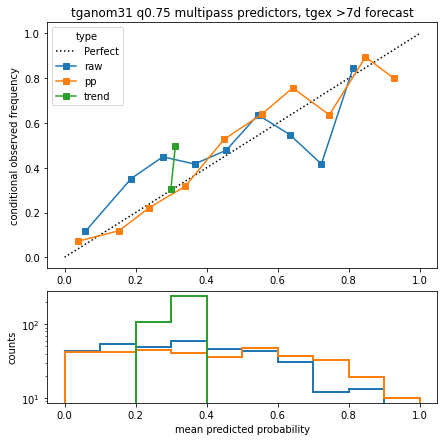

In [52]:
fig, (axrel, axhist) = reliability_plot(y_true = obs_test.iloc[:,focus_class], y_probs=complete_test)
axrel.set_title('tganom31 q0.75 multipass predictors, tgex >7d forecast')
plt.show()

(<Figure size 504x504 with 2 Axes>,
 [<AxesSubplot:ylabel='conditional observed frequency'>,
  <AxesSubplot:xlabel='mean predicted probability', ylabel='counts'>])

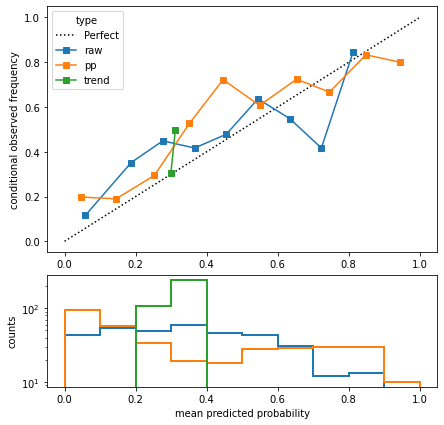

In [34]:
reliability_plot(y_true = obs_test.iloc[:,focus_class], y_probs=complete_test)

In [36]:
complete_train = pd.DataFrame({'raw':forc_trainval.iloc[:,focus_class], 'pp':model.predict(x = [feature_input, raw_predictions])[:,focus_class], 'trend': lr.predict(time_input)}, index = forc_trainval.index)
complete_train.columns.name = 'type'

(<Figure size 504x504 with 2 Axes>,
 [<AxesSubplot:ylabel='conditional observed frequency'>,
  <AxesSubplot:xlabel='mean predicted probability', ylabel='counts'>])

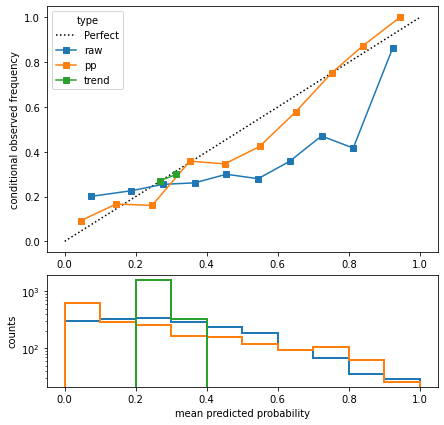

In [38]:
reliability_plot(y_true = obs_trainval.iloc[:,focus_class], y_probs =complete_train)